In [1]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from scipy.stats import skewnorm

#plotting stuff
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Myriad Pro"

# import local functions
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from functions.author_fns import *

%matplotlib inline

In [2]:
method = 'florida'
node_2_gender = np.load('%s/data/%s_node_2_gender.npy'%('..',method),allow_pickle='TRUE').item()
g = igraph.load('../data/florida_coa_graph',format='pickle')

In [3]:
nAuth = 256
nAuthSt = 200 # how many authors we start with
nYears = 23
meets_per_year = 10
learn_thr = .1
c = 3
diam = 3
net_size_o = 500
bib_length = 70
woman_perc_i = .36
meet_method = 'soc'
woman_perc_f = 0.5 #sum([x['gender'] == 'woman' for x in node_2_gender.values()])/len(node_2_gender)
colors = ['#d97d5b', '#4a3b90', '#5295d0', '#fabc50']

# original parameters
net_w = (.51,.01)
net_m = (.45,.01)
walk_w = (.60,.1)
walk_m = (.44,.1)
if meet_method == 'soc':
    meet_w = (0.04,0.005)
    meet_m = (0.06,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)


### CDS with 20 meets per year

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


All citers (w): 0.08039111241329519%, +/-0.03774805284332347
All citers (m): -0.05600017460611734%, +/-0.029654754920695015
W citers (w): 0.03237751824335763%, +/-0.034323342519743505
W citers (m): -0.018381555956449965%, +/-0.02776371825363309
M citers (w): 0.11738200434300398%, +/-0.04003488379990146
M citers (m): -0.08498251348476046%, +/-0.030911447242302444
All citers (w): 5.670172897718827, 3.8550475846080485e-08
All citers (m): -4.6890538280803415, 4.475762054631047e-06
W citers (w): 0.881191461443383, 0.3798920133158523
W citers (m): -0.4005558380519043, 0.6894255273429324
M citers (w): 9.365421120746516, 3.402083976642051e-16
M citers (m): -8.93649779099975, 3.749479670751595e-15


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Last timepoint: 11.48932112890923 +/- 6.615492247143562
All citers: -0.008496862295042339, 0.0002767156917921268
W citers: -0.009943359588546166, 0.0007028900636351899
M citers: -0.006612784448014268, 0.0023412055369464884


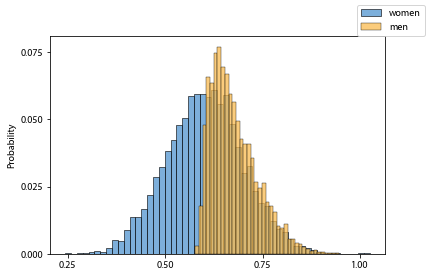

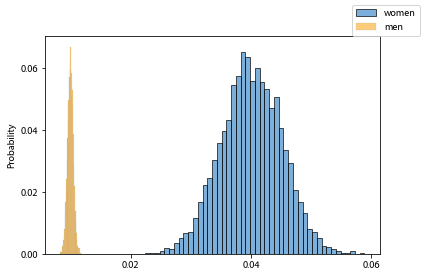

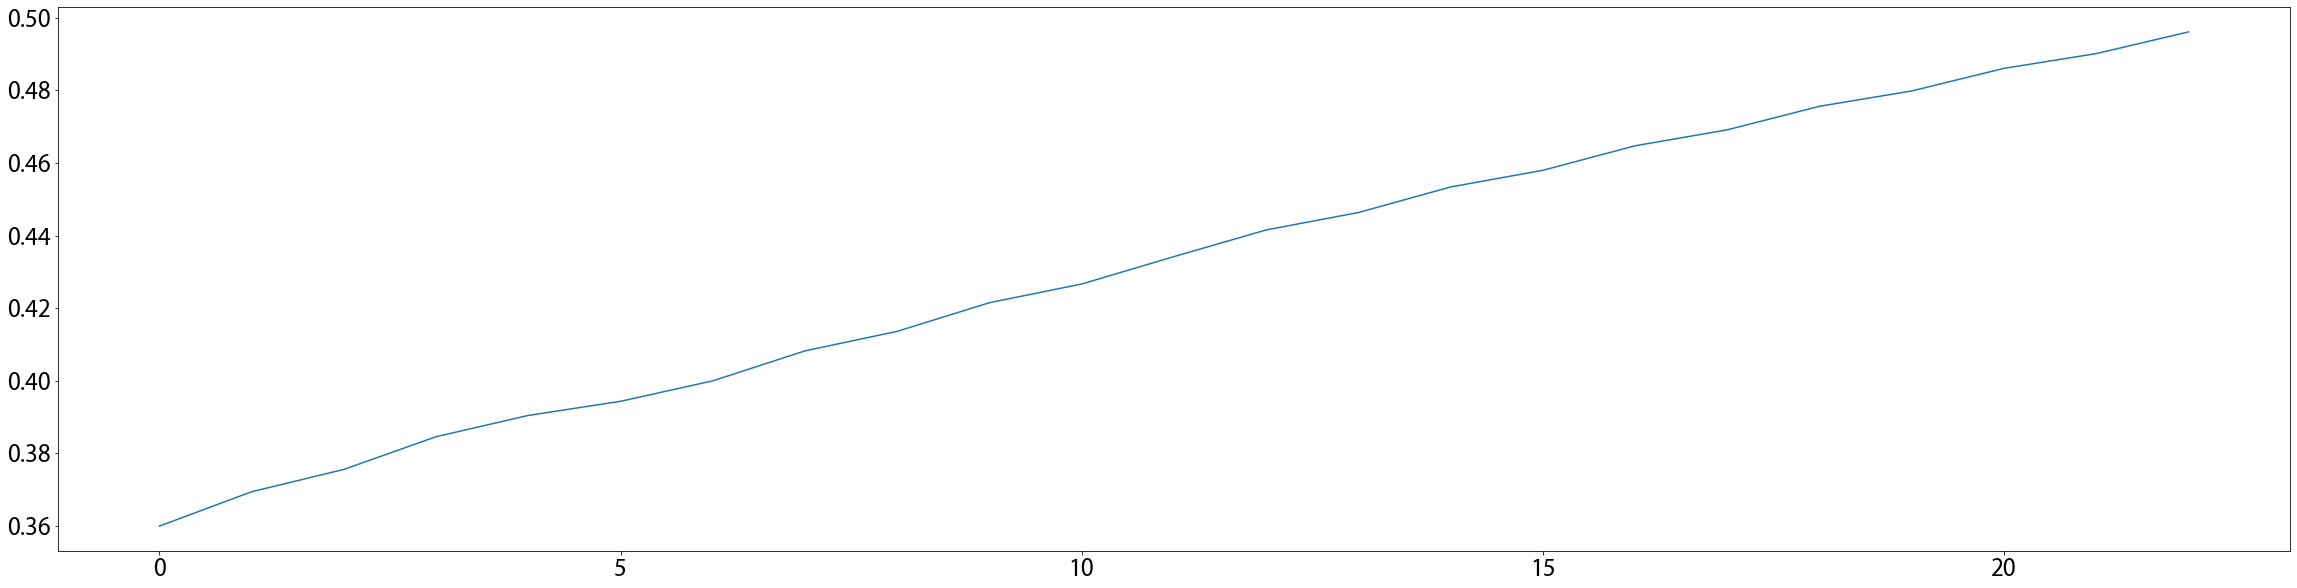

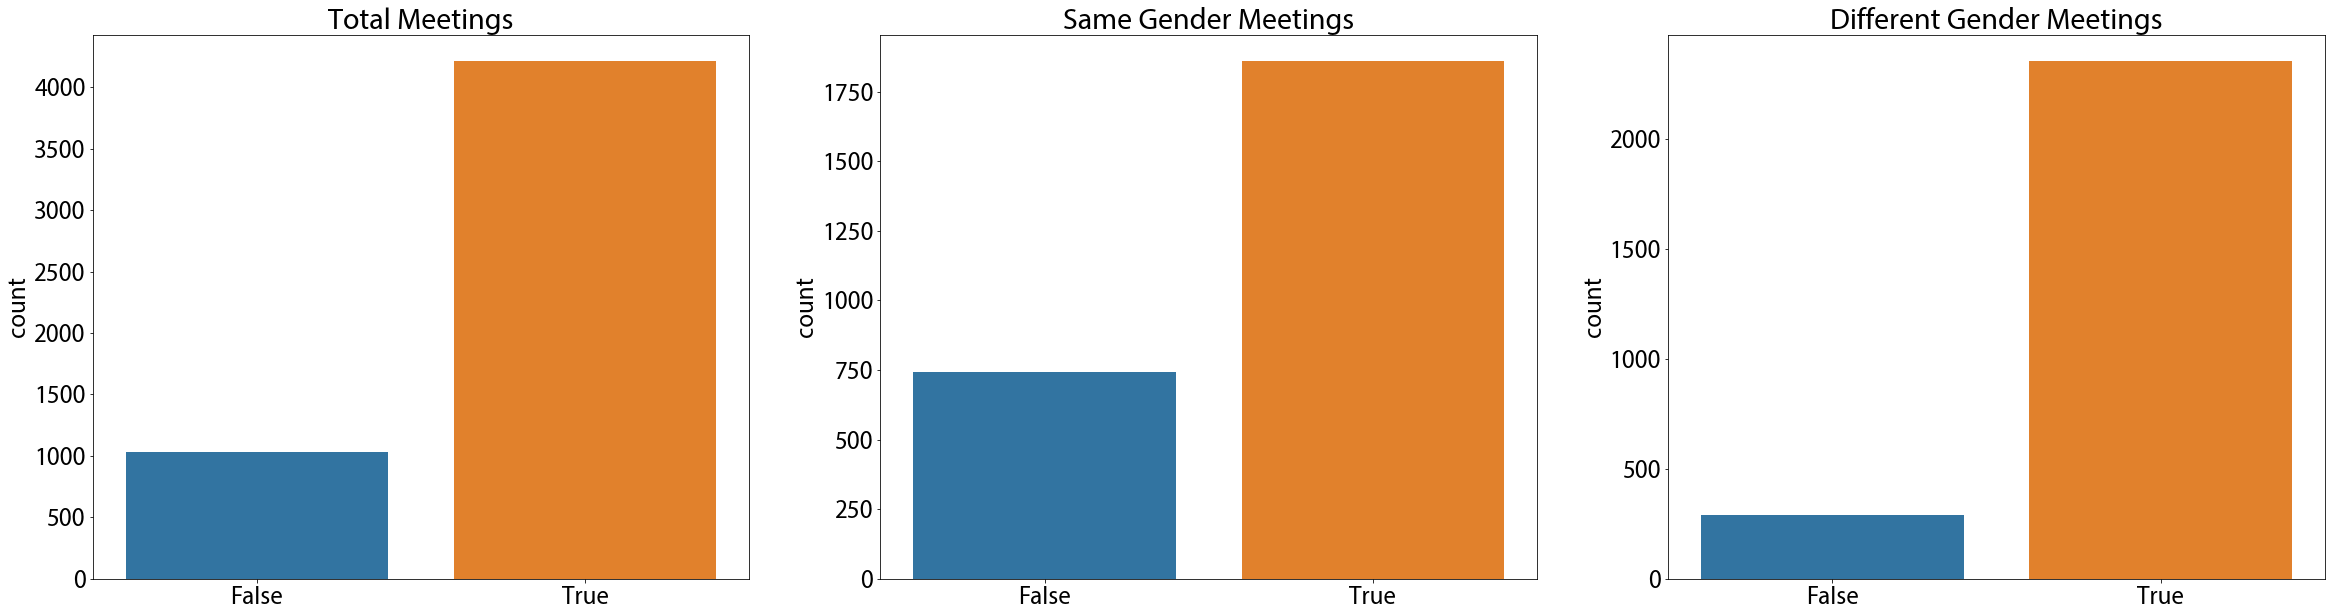

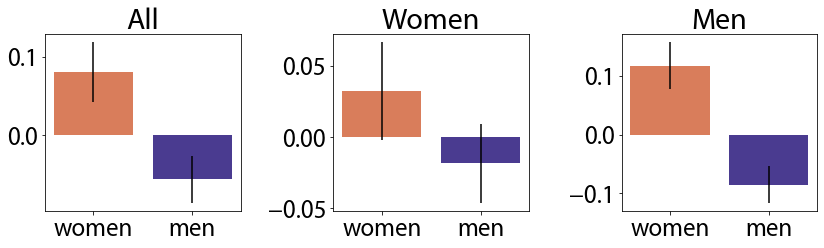

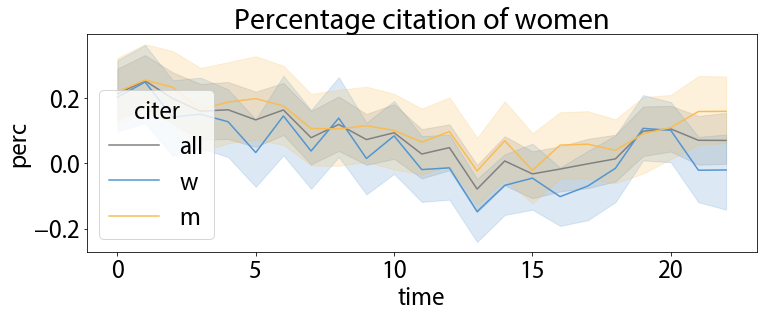

In [5]:
net_w = (.51,.01)
net_m = (.45,.01)
walk_w = (.60,.1)
walk_m = (.6,.1)
if meet_method == 'soc':
    meet_w = (0.04,0.005)
    meet_m = (0.01,0.0005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)

meets_per_year = 20

f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=walk_w[0],scale=walk_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(skewnorm.rvs(10, loc=walk_m[0],scale=walk_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig('../data/img/beta_cds.pdf')

f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=meet_w[0],scale=meet_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=meet_m[0],scale=meet_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig('../data/img/gamma_cds.pdf')

# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = skewnorm.rvs(10, loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gender=gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)
    

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nYears))
ns_w = np.round(ns*np.linspace(woman_perc_i, woman_perc_f, nYears))
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nYears):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    dw = ns_w[i] - sum([a.gender == 'W' for a in [authors[x] for x in sim_params[i-1]['author_idx']]])
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        a = []
        for j in range(int(dn)):
            if j <= dw:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = []
for i in range(nYears):
    print(i)
    #cProfile.run("tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])")
    tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'], meets_per_year)
    data.append(tmp)
    del tmp

# intialize final data structs
meets = {}; # keep track of when meetings were successful
net_size = []
bibs = {}
bibs_w = {}
bibs_m = {}
cite_perc = []
percs = [x['woman_perc'] for x in sim_params.values()]

# reformat data
cite_data = pd.DataFrame(columns=['perc','gen','time'])
prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
for i,d in enumerate(data):    
    curr_meets, ns, bs, bws, bms = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    net_size.append(ns)
    bibs[i] = bs
    bibs_w[i] = bws
    bibs_m[i] = bms

# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

# static plot
static_perc = np.empty((nYears,len(bibs[nYears-1])))
static_perc[:] = np.NaN
static_perc_w = np.empty((nYears,len(bibs_w[nYears-1])))
static_perc_w[:] = np.NaN
static_perc_m = np.empty((nYears,len(bibs_m[nYears-1])))
static_perc_m[:] = np.NaN
for i,b in enumerate(bibs.values()):
    # get all authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
        
for i,b in enumerate(bibs_w.values()):
    # get all w authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

for i,b in enumerate(bibs_m.values()):
    # get all m authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

plt.figure(figsize=(12,4))

plt.subplot(131)
amw = np.nanmean([(x-percs)/percs for x in static_perc.T])
asw = np.nanstd([(x-percs)/percs for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))
amm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])
asm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [amw, amm], color=colors)
plt.errorbar(['women','men'], [amw,amm], [asw, asm], fmt='none', color='k')
plt.title('All')
print('All citers (w): ' + str(amw) + '%, +/-' + str(asw))
print('All citers (m): ' + str(amm) + '%, +/-' + str(asm))

plt.subplot(132)
wmw = np.nanmean([(x-percs)/percs for x in static_perc_w.T])
wsw = np.nanstd([(x-percs)/percs for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))
wmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])
wsm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [wmw, wmm], color=colors)
plt.errorbar(['women','men'], [wmw,wmm],[wsw,wsm], fmt='none', color='k')
plt.title('Women')
print('W citers (w): ' + str(wmw) + '%, +/-' + str(wsw))
print('W citers (m): ' + str(wmm) + '%, +/-' + str(wsm))

plt.subplot(133)
mmw = np.nanmean([(x-percs)/percs for x in static_perc_m.T])
msw = np.nanstd([(x-percs)/percs for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))
mmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])
msm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [mmw,mmm], color=colors)
plt.errorbar(['women','men'], [mmw,mmm],[msw,msm], fmt='none', color='k')
plt.title('Men')
print('M citers (w): ' + str(mmw) + '%, +/-' + str(msw))
print('M citers (m): ' + str(mmm) + '%, +/-' + str(msm))
plt.tight_layout()
plt.savefig('../data/img/static_cites_cds20.pdf')

# stats
wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T],1),0)
print('All citers (w): ' + str(wt) + ', ' + str(wp))
print('All citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T],1),0)
print('W citers (w): ' + str(wt) + ', ' + str(wp))
print('W citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T],1),0)
print('M citers (w): ' + str(wt) + ', ' + str(wp))
print('M citers (m): ' + str(mt) + ', ' + str(mp))

cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
for i,b in bibs.items():
    curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    tmp_data = pd.DataFrame({'perc': curr_perc, 
                             'gen':['w']*len(curr_perc),
                             'citer':['all']*len(curr_perc),
                             'time':[i]*len(curr_perc)})
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_w.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # womens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                              'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                              'gen':gen,
                              'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_m.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # mens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                             'gen':gen, 
                             'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                             'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['gen'] == 'w'], x='time', y='perc', hue='citer',ax=ax, palette=['grey',colors[2],colors[3]])
ax.set_title('Percentage citation of women')
plt.savefig('../data/img/all_cite_w_cds20.pdf')
tv_data = cite_data[cite_data["gen"] == "w"]
print(f'Last timepoint: {str(tv_data.mean().values[-1])} +/- {str(tv_data.std().values[-1])}')

# stats
X = sm.add_constant(range(nYears))
y = cite_data[(cite_data['citer'] == 'all') & (cite_data['gen'] == 'w')].groupby('time').mean().values
mod = sm.OLS(y, X)
res = mod.fit()
yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modw = sm.OLS(yw, X)
resw = modw.fit()
ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modm = sm.OLS(ym, X)
resm = modm.fit()

print('All citers: ' + str(res.params[1]) + ', ' + str(res.pvalues[1]))
print('W citers: ' + str(resw.params[1]) + ', ' + str(resw.pvalues[1]))
print('M citers: ' + str(resm.params[1]) + ', ' + str(resm.pvalues[1]))
      

## Different values of gamma

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


All citers (w): -0.1548347640121818%, +/-0.02529556871690229
All citers (m): 0.12988468834648503%, +/-0.01969603292977905
W citers (w): -0.022966300988452055%, +/-0.025534340027535185
W citers (m): 0.029803664082785803%, +/-0.019841435141290522
M citers (w): -0.2564295758353254%, +/-0.023191902696869684
M citers (m): 0.20698965032142144%, +/-0.018169694396497356
All citers (w): -10.580202211464215, 6.312197778198105e-22
All citers (m): 11.394347829005044, 1.3894718622303594e-24
W citers (w): -1.9323545404424576, 0.05556005113540493
W citers (m): 2.6260870938904874, 0.009707771716277838
M citers (w): -18.231204241939242, 2.1833781772604155e-37
M citers (m): 19.416993004984445, 5.7483360027712886e-40


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


All citers: -0.011102740126504421, 1.8448323520858595e-13
W citers: -0.014639621318381145, 4.3783142237439636e-11
M citers: -0.01123175722726276, 1.394336838522745e-12


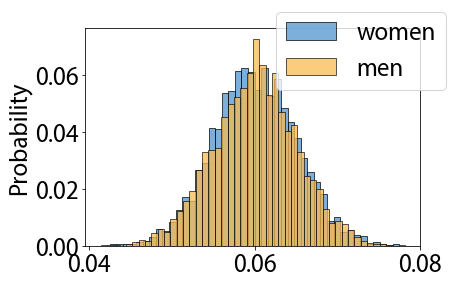

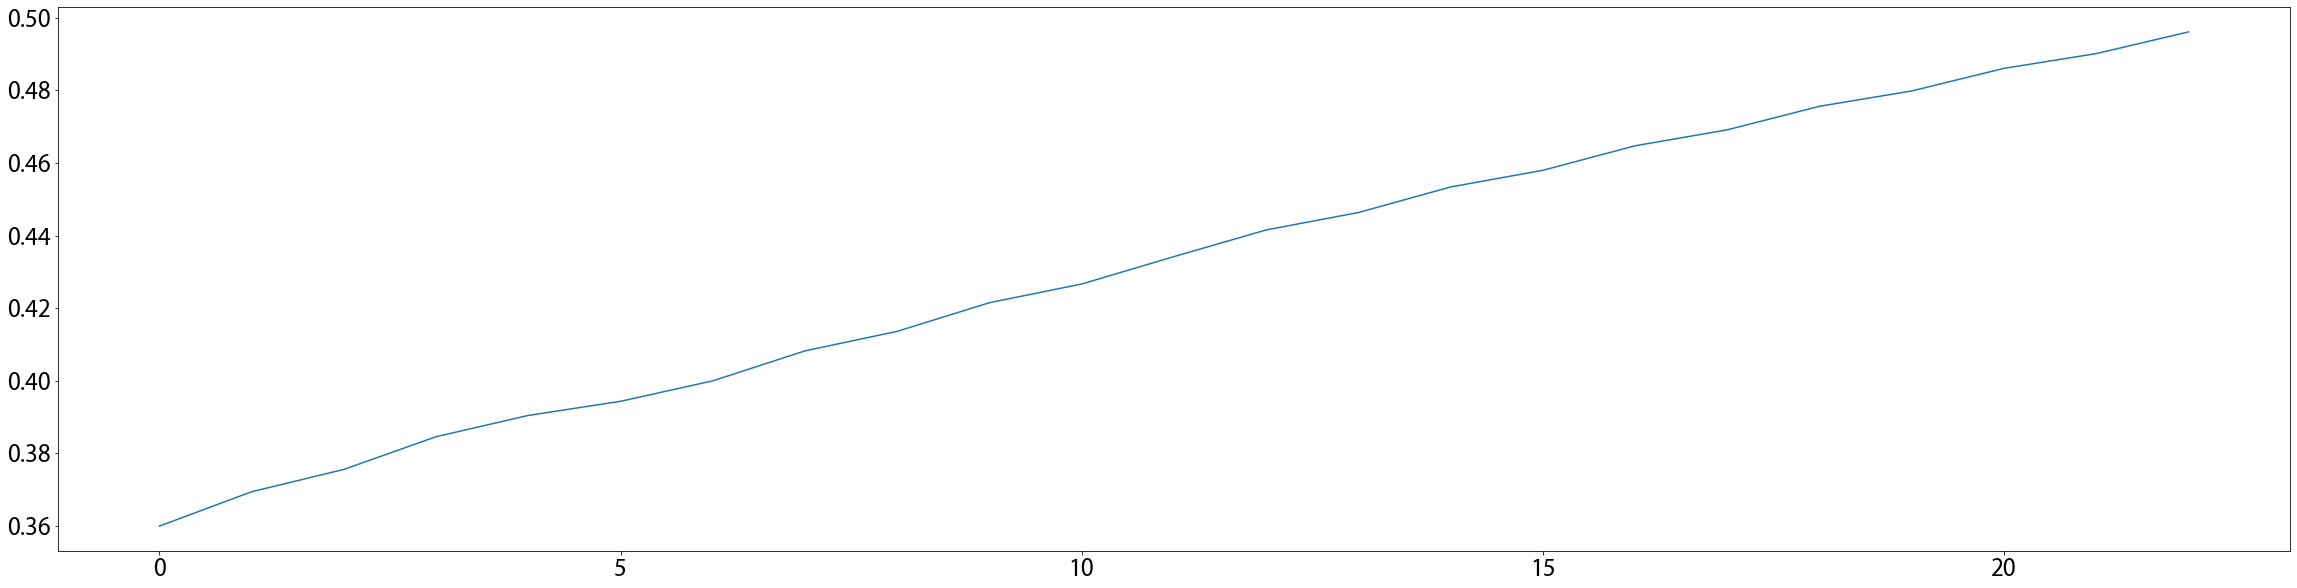

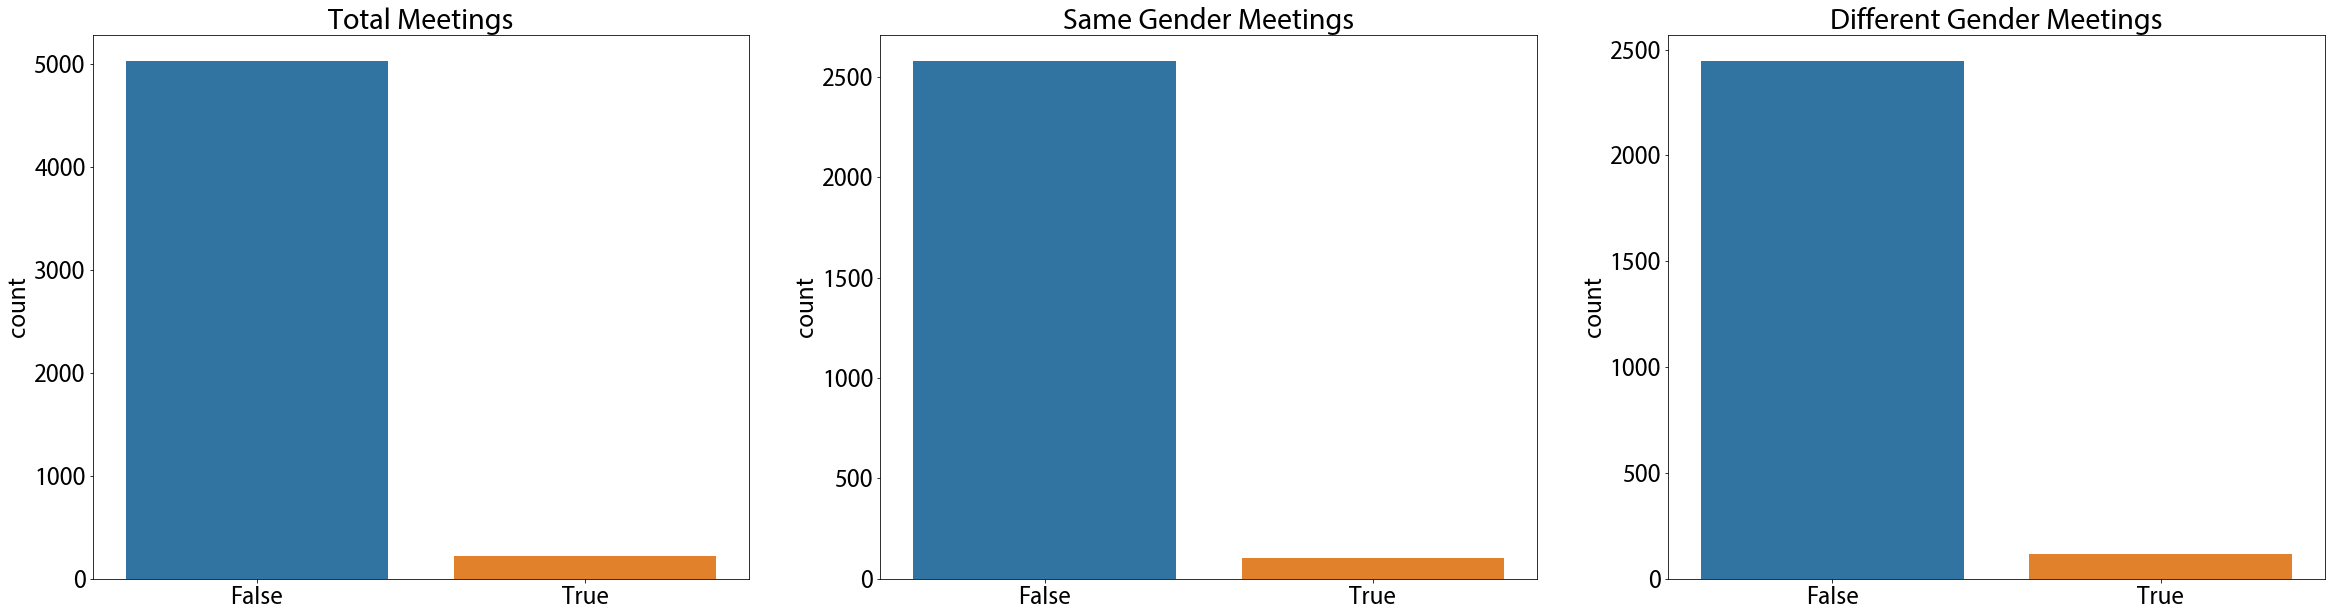

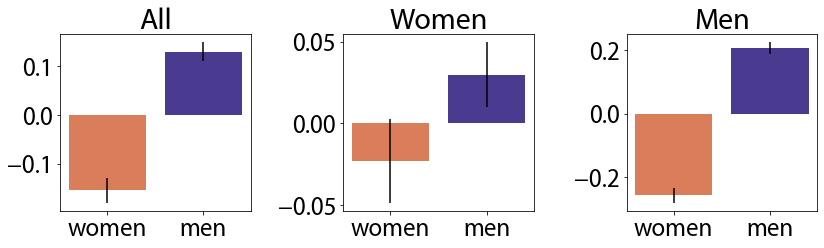

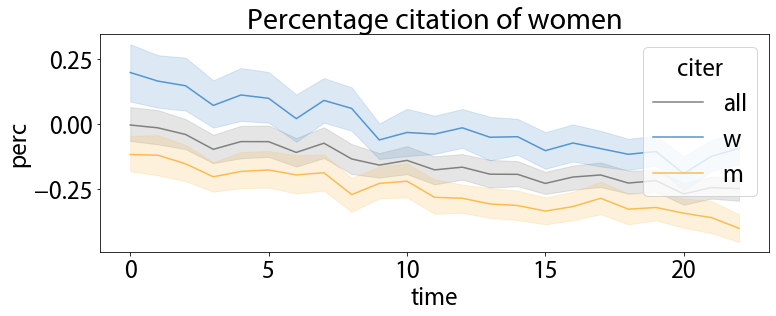

In [6]:
net_w = (.51,.01)
net_m = (.45,.01)
walk_w = (.60,.1)
walk_m = (.44,.1)
if meet_method == 'soc':
    meet_w = (0.06,0.005)
    meet_m = (0.06,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)

meets_per_year = 10
ext = 'gamma_same'

f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=meet_w[0],scale=meet_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=meet_m[0],scale=meet_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig(f'../data/img/{ext}.pdf')

# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = skewnorm.rvs(10, loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gender=gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)
    

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nYears))
ns_w = np.round(ns*np.linspace(woman_perc_i, woman_perc_f, nYears))
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nYears):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    dw = ns_w[i] - sum([a.gender == 'W' for a in [authors[x] for x in sim_params[i-1]['author_idx']]])
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        a = []
        for j in range(int(dn)):
            if j <= dw:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = []
for i,b in enumerate(range(nYears)):
    #cProfile.run("tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])")
    tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'], meets_per_year)
    data.append(tmp)
    del tmp

# intialize final data structs
meets = {}; # keep track of when meetings were successful
net_size = []
bibs = {}
bibs_w = {}
bibs_m = {}
cite_perc = []
percs = [x['woman_perc'] for x in sim_params.values()]

# reformat data
cite_data = pd.DataFrame(columns=['perc','gen','time'])
prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
for i,d in enumerate(data):    
    curr_meets, ns, bs, bws, bms = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    net_size.append(ns)
    bibs[i] = bs
    bibs_w[i] = bws
    bibs_m[i] = bms

# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

# static plot
static_perc = np.empty((nYears,len(bibs[nYears-1])))
static_perc[:] = np.NaN
static_perc_w = np.empty((nYears,len(bibs_w[nYears-1])))
static_perc_w[:] = np.NaN
static_perc_m = np.empty((nYears,len(bibs_m[nYears-1])))
static_perc_m[:] = np.NaN
for i,b in enumerate(bibs.values()):
    # get all authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
        
for i,b in enumerate(bibs_w.values()):
    # get all w authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

for i,b in enumerate(bibs_m.values()):
    # get all m authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

plt.figure(figsize=(12,4))

plt.subplot(131)
amw = np.nanmean([(x-percs)/percs for x in static_perc.T])
asw = np.nanstd([(x-percs)/percs for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))
amm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])
asm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [amw, amm], color=colors)
plt.errorbar(['women','men'], [amw,amm], [asw, asm], fmt='none', color='k')
plt.title('All')
print('All citers (w): ' + str(amw) + '%, +/-' + str(asw))
print('All citers (m): ' + str(amm) + '%, +/-' + str(asm))

plt.subplot(132)
wmw = np.nanmean([(x-percs)/percs for x in static_perc_w.T])
wsw = np.nanstd([(x-percs)/percs for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))
wmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])
wsm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [wmw, wmm], color=colors)
plt.errorbar(['women','men'], [wmw,wmm],[wsw,wsm], fmt='none', color='k')
plt.title('Women')
print('W citers (w): ' + str(wmw) + '%, +/-' + str(wsw))
print('W citers (m): ' + str(wmm) + '%, +/-' + str(wsm))

plt.subplot(133)
mmw = np.nanmean([(x-percs)/percs for x in static_perc_m.T])
msw = np.nanstd([(x-percs)/percs for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))
mmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])
msm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [mmw,mmm], color=colors)
plt.errorbar(['women','men'], [mmw,mmm],[msw,msm], fmt='none', color='k')
plt.title('Men')
print('M citers (w): ' + str(mmw) + '%, +/-' + str(msw))
print('M citers (m): ' + str(mmm) + '%, +/-' + str(msm))
plt.tight_layout()
plt.savefig(f'../data/img/static_cites_{ext}.pdf')

# stats
wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T],1),0)
print('All citers (w): ' + str(wt) + ', ' + str(wp))
print('All citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T],1),0)
print('W citers (w): ' + str(wt) + ', ' + str(wp))
print('W citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T],1),0)
print('M citers (w): ' + str(wt) + ', ' + str(wp))
print('M citers (m): ' + str(mt) + ', ' + str(mp))

cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
for i,b in bibs.items():
    curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    tmp_data = pd.DataFrame({'perc': curr_perc, 
                             'gen':['w']*len(curr_perc),
                             'citer':['all']*len(curr_perc),
                             'time':[i]*len(curr_perc)})
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_w.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # womens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                              'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                              'gen':gen,
                              'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_m.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # mens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                             'gen':gen, 
                             'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                             'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['gen'] == 'w'], x='time', y='perc', hue='citer',ax=ax, palette=['grey',colors[2],colors[3]])
ax.set_title('Percentage citation of women')
plt.savefig(f'../data/img/all_cite_w_{ext}.pdf')

# stats
X = sm.add_constant(range(nYears))
y = cite_data[(cite_data['citer'] == 'all') & (cite_data['gen'] == 'w')].groupby('time').mean().values
mod = sm.OLS(y, X)
res = mod.fit()
yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modw = sm.OLS(yw, X)
resw = modw.fit()
ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modm = sm.OLS(ym, X)
resm = modm.fit()

print('All citers: ' + str(res.params[1]) + ', ' + str(res.pvalues[1]))
print('W citers: ' + str(resw.params[1]) + ', ' + str(resw.pvalues[1]))
print('M citers: ' + str(resm.params[1]) + ', ' + str(resm.pvalues[1]))

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


All citers (w): -0.18396691971732484%, +/-0.02904398991180177
All citers (m): 0.15431809570688843%, +/-0.022911370645119014
W citers (w): -0.05998503361192444%, +/-0.03516504202155517
W citers (m): 0.06464005557751291%, +/-0.027831296174670693
M citers (w): -0.2794857124561917%, +/-0.02142090908316094
M citers (m): 0.2234083345911676%, +/-0.01702190117142614
All citers (w): -13.059638418612732, 3.438988747158382e-30
All citers (m): 13.86650167829164, 5.8124532820379805e-33
W citers (w): -3.706926494025527, 0.0003129621470710786
W citers (m): 4.503155845103351, 1.5064028337447015e-05
M citers (w): -21.117157693480003, 1.5688624719330873e-43
M citers (m): 22.20884475150227, 9.769759387175245e-46


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


All citers: -0.013163244130358588, 4.591616786873344e-13
W citers: -0.02178167531776392, 3.3538216635142123e-10
M citers: -0.009620548412208399, 5.710573867231829e-12


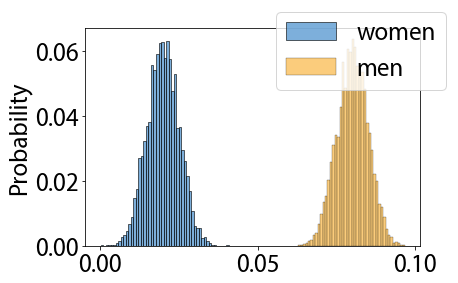

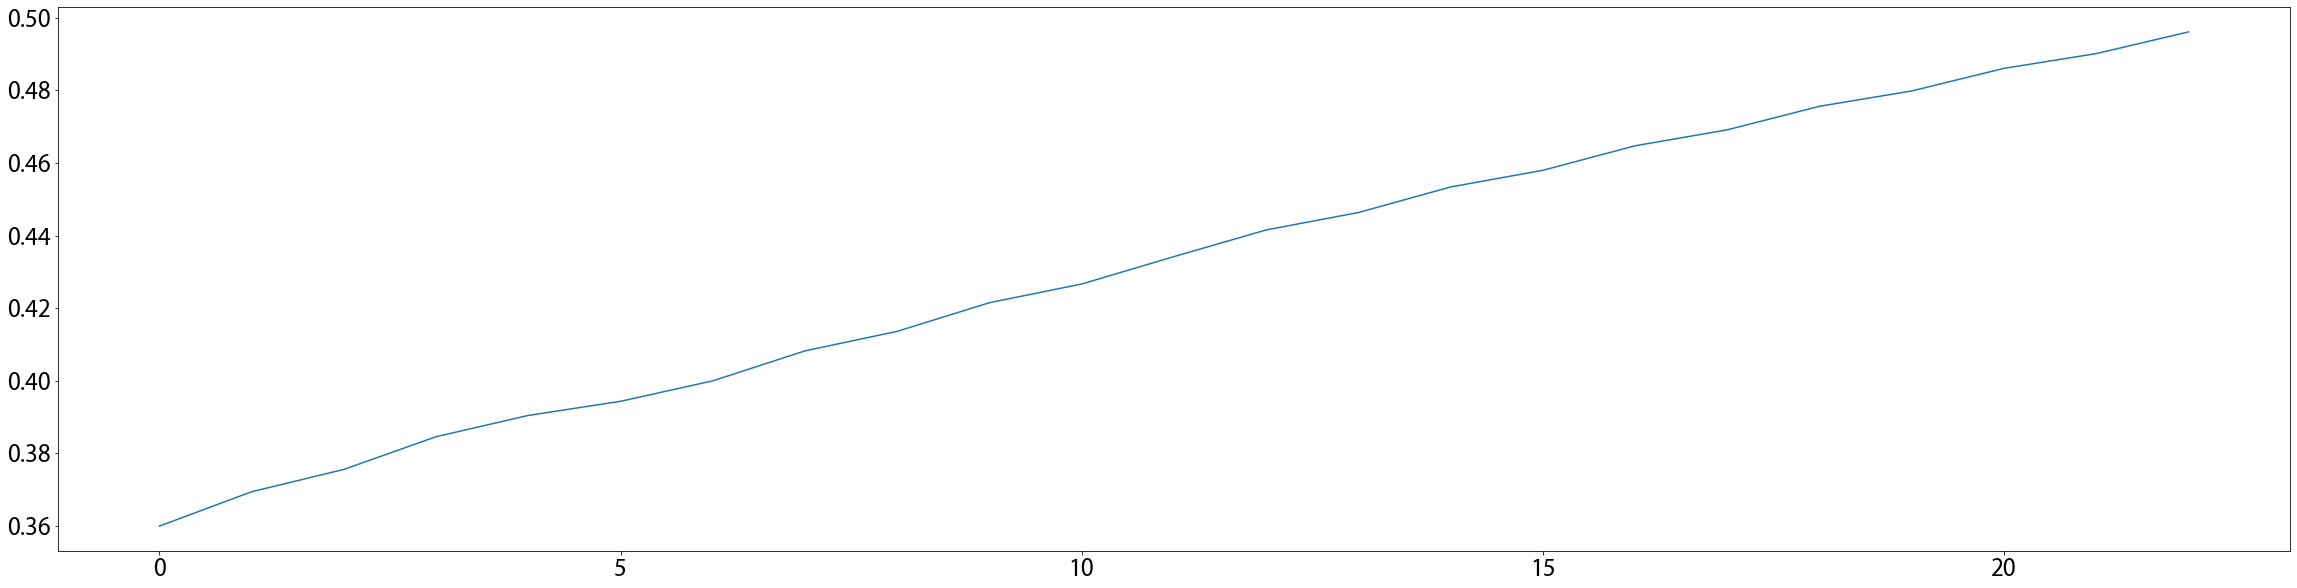

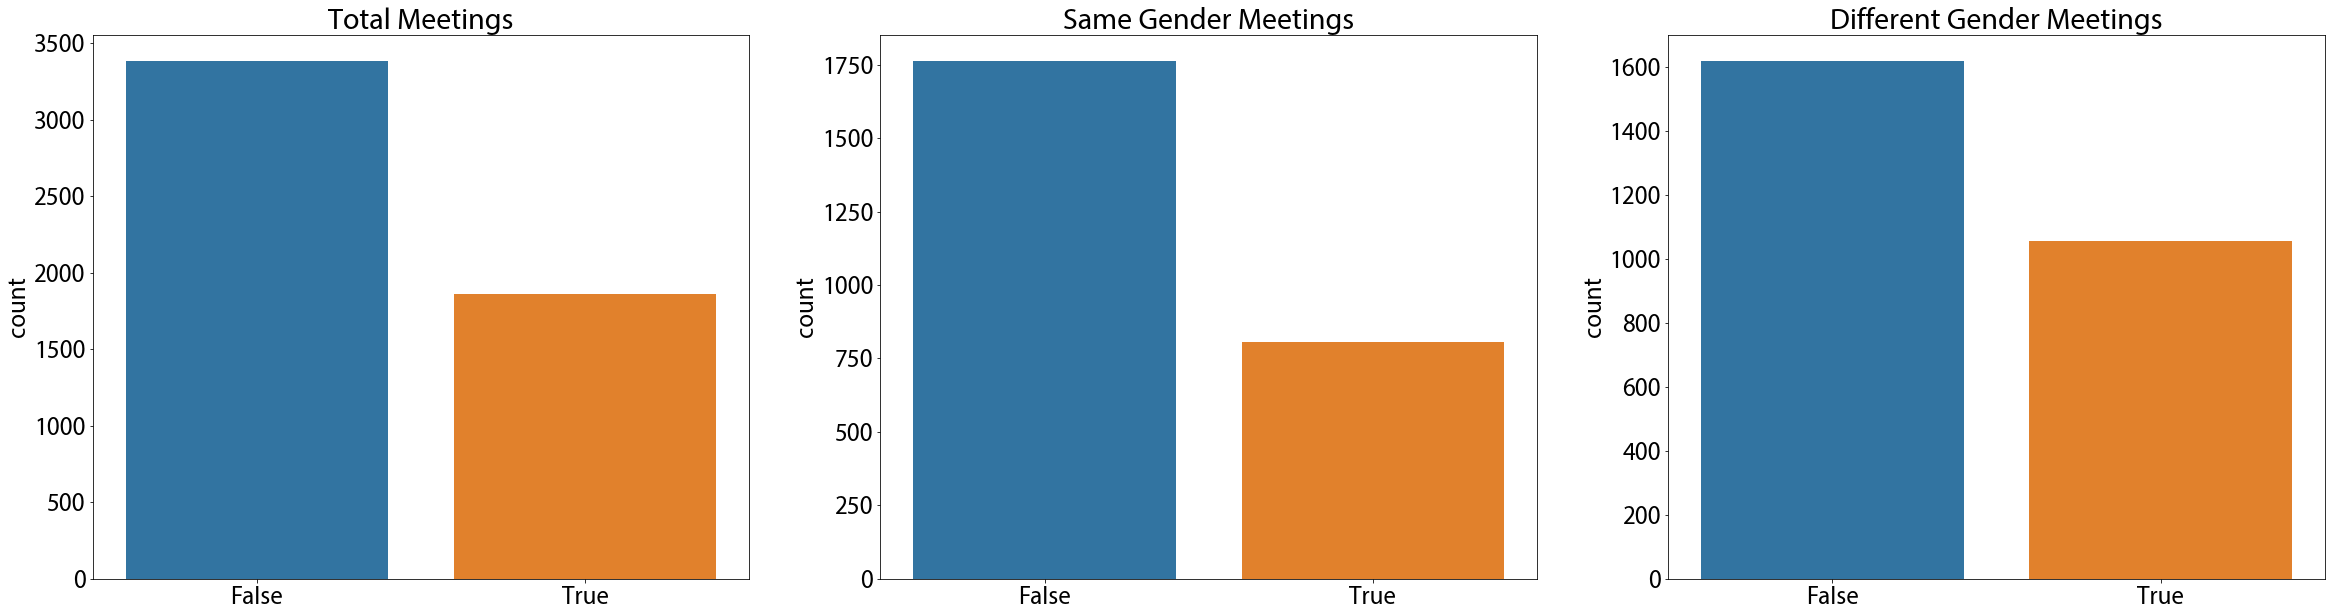

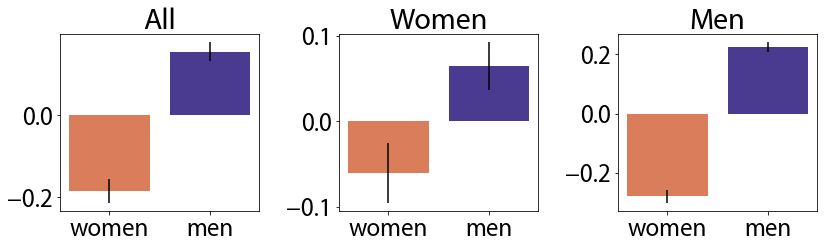

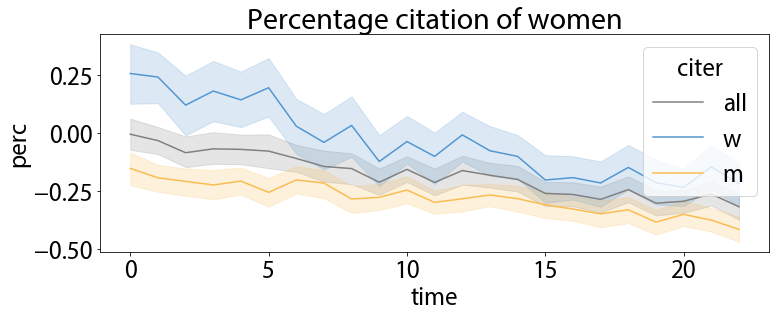

In [7]:
net_w = (.51,.01)
net_m = (.45,.01)
walk_w = (.60,.1)
walk_m = (.44,.1)
if meet_method == 'soc':
    meet_w = (0.02,0.005)
    meet_m = (0.08,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-1,.75)
learn_m = (-1,.75)

meets_per_year = 10
ext = 'gamma_diff'

f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=meet_w[0],scale=meet_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=meet_m[0],scale=meet_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig(f'../data/img/{ext}.pdf')

# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = skewnorm.rvs(10, loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gender=gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)
    

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nYears))
ns_w = np.round(ns*np.linspace(woman_perc_i, woman_perc_f, nYears))
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nYears):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    dw = ns_w[i] - sum([a.gender == 'W' for a in [authors[x] for x in sim_params[i-1]['author_idx']]])
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        a = []
        for j in range(int(dn)):
            if j <= dw:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = []
for i,b in enumerate(range(nYears)):
    #cProfile.run("tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])")
    tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'], meets_per_year)
    data.append(tmp)
    del tmp

# intialize final data structs
meets = {}; # keep track of when meetings were successful
net_size = []
bibs = {}
bibs_w = {}
bibs_m = {}
cite_perc = []
percs = [x['woman_perc'] for x in sim_params.values()]

# reformat data
cite_data = pd.DataFrame(columns=['perc','gen','time'])
prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
for i,d in enumerate(data):    
    curr_meets, ns, bs, bws, bms = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    net_size.append(ns)
    bibs[i] = bs
    bibs_w[i] = bws
    bibs_m[i] = bms

# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

# static plot
static_perc = np.empty((nYears,len(bibs[nYears-1])))
static_perc[:] = np.NaN
static_perc_w = np.empty((nYears,len(bibs_w[nYears-1])))
static_perc_w[:] = np.NaN
static_perc_m = np.empty((nYears,len(bibs_m[nYears-1])))
static_perc_m[:] = np.NaN
for i,b in enumerate(bibs.values()):
    # get all authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
        
for i,b in enumerate(bibs_w.values()):
    # get all w authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

for i,b in enumerate(bibs_m.values()):
    # get all m authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

plt.figure(figsize=(12,4))

plt.subplot(131)
amw = np.nanmean([(x-percs)/percs for x in static_perc.T])
asw = np.nanstd([(x-percs)/percs for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))
amm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])
asm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [amw, amm], color=colors)
plt.errorbar(['women','men'], [amw,amm], [asw, asm], fmt='none', color='k')
plt.title('All')
print('All citers (w): ' + str(amw) + '%, +/-' + str(asw))
print('All citers (m): ' + str(amm) + '%, +/-' + str(asm))

plt.subplot(132)
wmw = np.nanmean([(x-percs)/percs for x in static_perc_w.T])
wsw = np.nanstd([(x-percs)/percs for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))
wmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])
wsm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [wmw, wmm], color=colors)
plt.errorbar(['women','men'], [wmw,wmm],[wsw,wsm], fmt='none', color='k')
plt.title('Women')
print('W citers (w): ' + str(wmw) + '%, +/-' + str(wsw))
print('W citers (m): ' + str(wmm) + '%, +/-' + str(wsm))

plt.subplot(133)
mmw = np.nanmean([(x-percs)/percs for x in static_perc_m.T])
msw = np.nanstd([(x-percs)/percs for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))
mmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])
msm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [mmw,mmm], color=colors)
plt.errorbar(['women','men'], [mmw,mmm],[msw,msm], fmt='none', color='k')
plt.title('Men')
print('M citers (w): ' + str(mmw) + '%, +/-' + str(msw))
print('M citers (m): ' + str(mmm) + '%, +/-' + str(msm))
plt.tight_layout()
plt.savefig(f'../data/img/static_cites_{ext}.pdf')

# stats
wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T],1),0)
print('All citers (w): ' + str(wt) + ', ' + str(wp))
print('All citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T],1),0)
print('W citers (w): ' + str(wt) + ', ' + str(wp))
print('W citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T],1),0)
print('M citers (w): ' + str(wt) + ', ' + str(wp))
print('M citers (m): ' + str(mt) + ', ' + str(mp))

cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
for i,b in bibs.items():
    curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    tmp_data = pd.DataFrame({'perc': curr_perc, 
                             'gen':['w']*len(curr_perc),
                             'citer':['all']*len(curr_perc),
                             'time':[i]*len(curr_perc)})
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_w.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # womens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                              'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                              'gen':gen,
                              'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_m.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # mens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                             'gen':gen, 
                             'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                             'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['gen'] == 'w'], x='time', y='perc', hue='citer',ax=ax, palette=['grey',colors[2],colors[3]])
ax.set_title('Percentage citation of women')
plt.savefig(f'../data/img/all_cite_w_{ext}.pdf')

# stats
X = sm.add_constant(range(nYears))
y = cite_data[(cite_data['citer'] == 'all') & (cite_data['gen'] == 'w')].groupby('time').mean().values
mod = sm.OLS(y, X)
res = mod.fit()
yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modw = sm.OLS(yw, X)
resw = modw.fit()
ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modm = sm.OLS(ym, X)
resm = modm.fit()

print('All citers: ' + str(res.params[1]) + ', ' + str(res.pvalues[1]))
print('W citers: ' + str(resw.params[1]) + ', ' + str(resw.pvalues[1]))
print('M citers: ' + str(resm.params[1]) + ', ' + str(resm.pvalues[1]))

## Different values of zeta

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


All citers (w): -0.16763355113511377%, +/-0.026099168033853953
All citers (m): 0.13992191650210972%, +/-0.020408150832290695
W citers (w): -0.026389651416249434%, +/-0.027743063090231983
W citers (m): 0.03294995921331451%, +/-0.021763105127924957
M citers (w): -0.2764514374141308%, +/-0.022509592119044075
M citers (m): 0.22233582822831852%, +/-0.01764940649231448
All citers (w): -10.766974322836163, 1.572678353431337e-22
All citers (m): 11.42697179218425, 1.0839813997646697e-24
W citers (w): -1.3132721373577303, 0.1914778045369528
W citers (m): 1.8839953271527865, 0.061870021342143804
M citers (w): -22.75677954268034, 8.067411812462087e-47
M citers (m): 24.39995381924077, 5.648021966537208e-50


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


All citers: -0.011171724770232499, 7.557433239357872e-13
W citers: -0.014879746489567598, 7.744567906220102e-11
M citers: -0.011210871181177008, 4.3098835494403957e-11


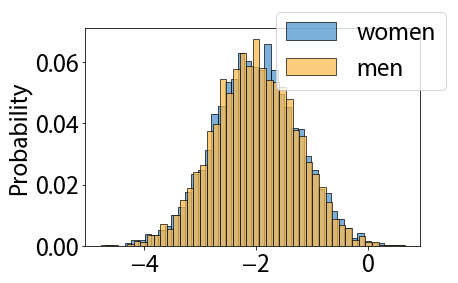

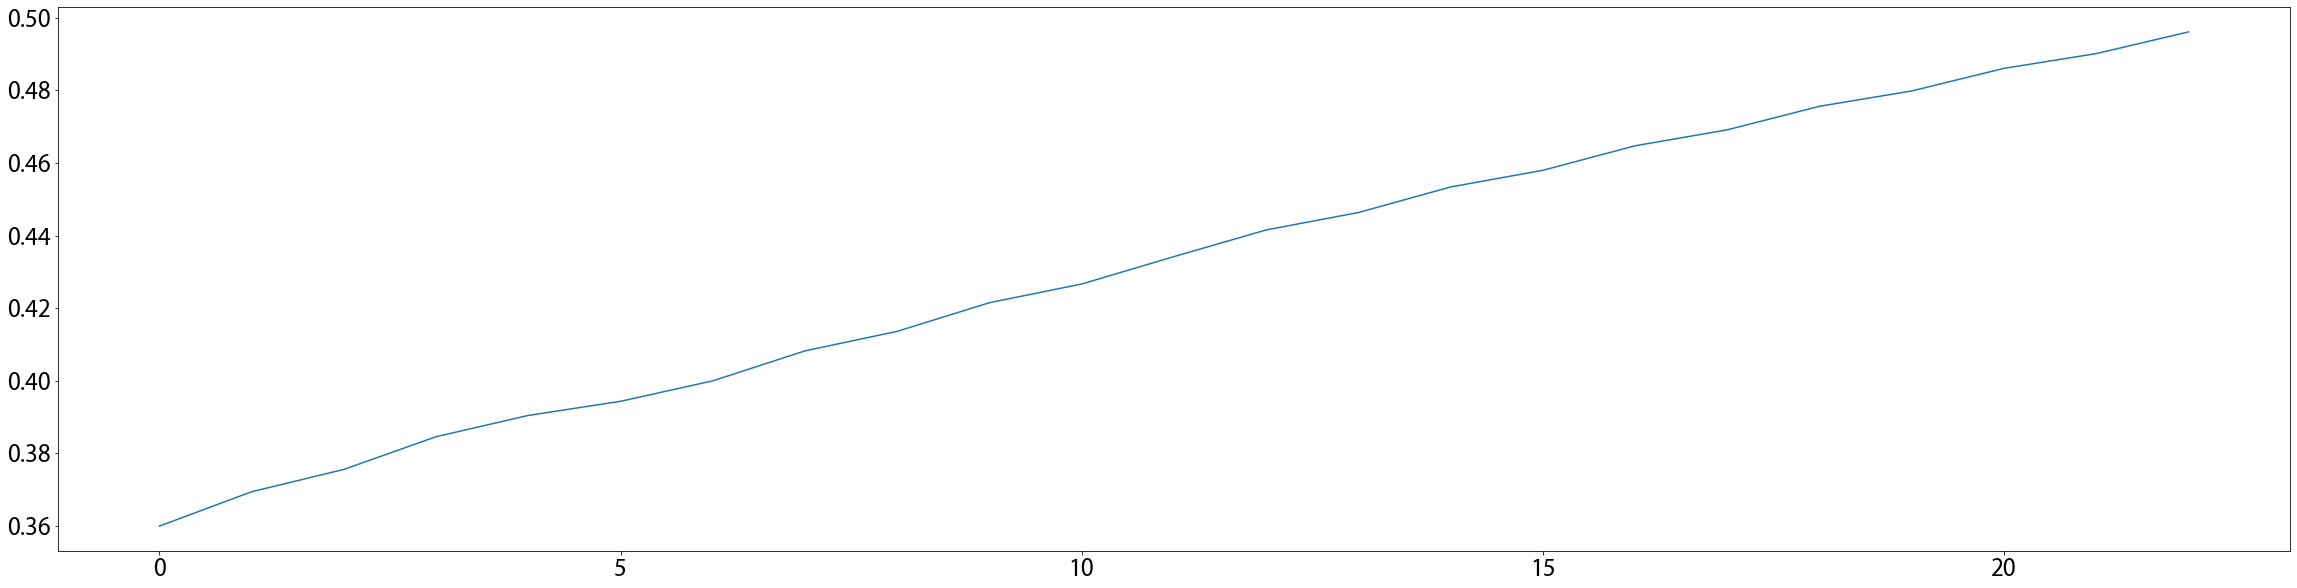

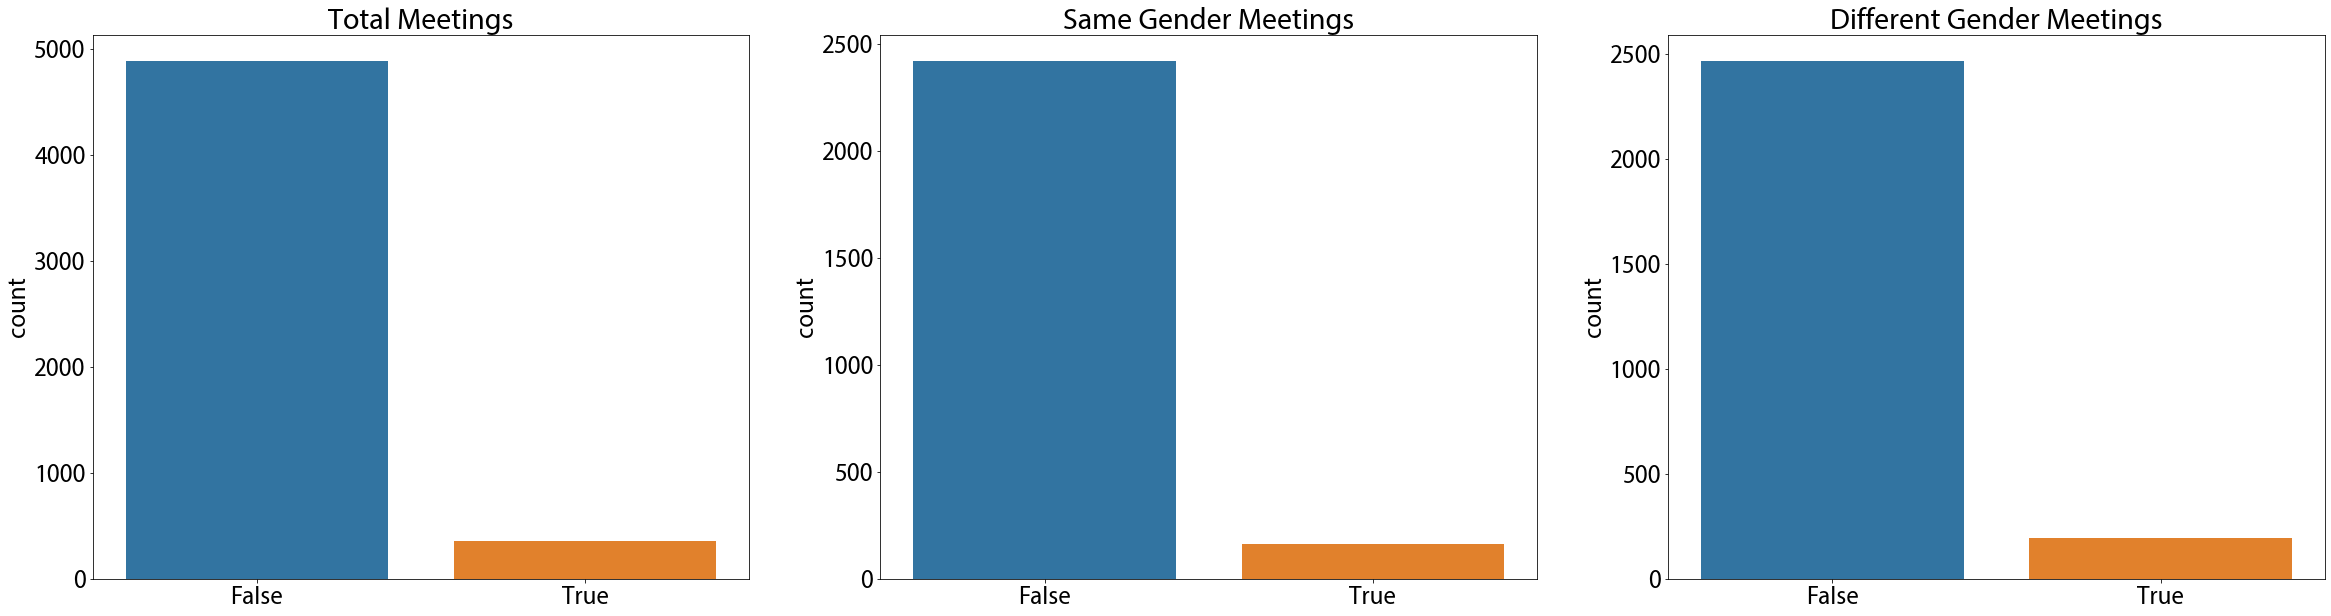

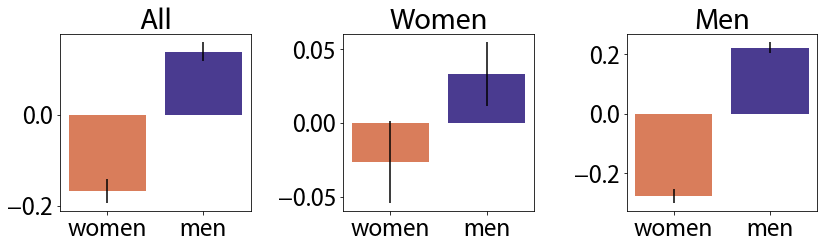

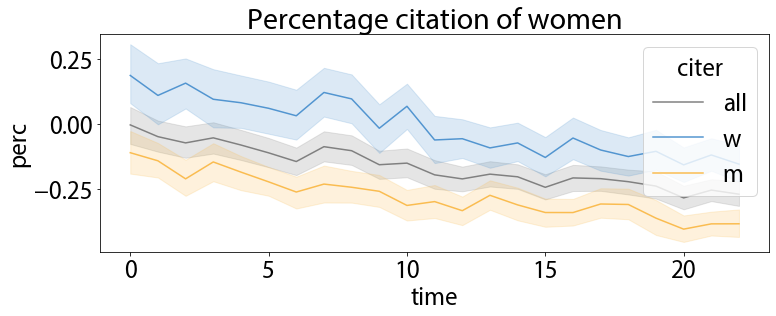

In [8]:
net_w = (.51,.01)
net_m = (.45,.01)
walk_w = (.60,.1)
walk_m = (.44,.1)
if meet_method == 'soc':
    meet_w = (0.04,0.005)
    meet_m = (0.06,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (-2,.75)
learn_m = (-2,.75)

meets_per_year = 10
ext = 'zeta_small'

f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=learn_w[0],scale=learn_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=learn_m[0],scale=learn_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig(f'../data/img/{ext}.pdf')

# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = skewnorm.rvs(10, loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gender=gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)
    

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nYears))
ns_w = np.round(ns*np.linspace(woman_perc_i, woman_perc_f, nYears))
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nYears):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    dw = ns_w[i] - sum([a.gender == 'W' for a in [authors[x] for x in sim_params[i-1]['author_idx']]])
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        a = []
        for j in range(int(dn)):
            if j <= dw:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = []
for i,b in enumerate(range(nYears)):
    #cProfile.run("tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])")
    tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'], meets_per_year)
    data.append(tmp)
    del tmp

# intialize final data structs
meets = {}; # keep track of when meetings were successful
net_size = []
bibs = {}
bibs_w = {}
bibs_m = {}
cite_perc = []
percs = [x['woman_perc'] for x in sim_params.values()]

# reformat data
cite_data = pd.DataFrame(columns=['perc','gen','time'])
prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
for i,d in enumerate(data):    
    curr_meets, ns, bs, bws, bms = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    net_size.append(ns)
    bibs[i] = bs
    bibs_w[i] = bws
    bibs_m[i] = bms

# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

# static plot
static_perc = np.empty((nYears,len(bibs[nYears-1])))
static_perc[:] = np.NaN
static_perc_w = np.empty((nYears,len(bibs_w[nYears-1])))
static_perc_w[:] = np.NaN
static_perc_m = np.empty((nYears,len(bibs_m[nYears-1])))
static_perc_m[:] = np.NaN
for i,b in enumerate(bibs.values()):
    # get all authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
        
for i,b in enumerate(bibs_w.values()):
    # get all w authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

for i,b in enumerate(bibs_m.values()):
    # get all m authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

plt.figure(figsize=(12,4))

plt.subplot(131)
amw = np.nanmean([(x-percs)/percs for x in static_perc.T])
asw = np.nanstd([(x-percs)/percs for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))
amm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])
asm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [amw, amm], color=colors)
plt.errorbar(['women','men'], [amw,amm], [asw, asm], fmt='none', color='k')
plt.title('All')
print('All citers (w): ' + str(amw) + '%, +/-' + str(asw))
print('All citers (m): ' + str(amm) + '%, +/-' + str(asm))

plt.subplot(132)
wmw = np.nanmean([(x-percs)/percs for x in static_perc_w.T])
wsw = np.nanstd([(x-percs)/percs for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))
wmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])
wsm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [wmw, wmm], color=colors)
plt.errorbar(['women','men'], [wmw,wmm],[wsw,wsm], fmt='none', color='k')
plt.title('Women')
print('W citers (w): ' + str(wmw) + '%, +/-' + str(wsw))
print('W citers (m): ' + str(wmm) + '%, +/-' + str(wsm))

plt.subplot(133)
mmw = np.nanmean([(x-percs)/percs for x in static_perc_m.T])
msw = np.nanstd([(x-percs)/percs for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))
mmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])
msm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [mmw,mmm], color=colors)
plt.errorbar(['women','men'], [mmw,mmm],[msw,msm], fmt='none', color='k')
plt.title('Men')
print('M citers (w): ' + str(mmw) + '%, +/-' + str(msw))
print('M citers (m): ' + str(mmm) + '%, +/-' + str(msm))
plt.tight_layout()
plt.savefig(f'../data/img/static_cites_{ext}.pdf')

# stats
wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T],1),0)
print('All citers (w): ' + str(wt) + ', ' + str(wp))
print('All citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T],1),0)
print('W citers (w): ' + str(wt) + ', ' + str(wp))
print('W citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T],1),0)
print('M citers (w): ' + str(wt) + ', ' + str(wp))
print('M citers (m): ' + str(mt) + ', ' + str(mp))

cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
for i,b in bibs.items():
    curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    tmp_data = pd.DataFrame({'perc': curr_perc, 
                             'gen':['w']*len(curr_perc),
                             'citer':['all']*len(curr_perc),
                             'time':[i]*len(curr_perc)})
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_w.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # womens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                              'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                              'gen':gen,
                              'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_m.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # mens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                             'gen':gen, 
                             'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                             'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['gen'] == 'w'], x='time', y='perc', hue='citer',ax=ax, palette=['grey',colors[2],colors[3]])
ax.set_title('Percentage citation of women')
plt.savefig(f'../data/img/all_cite_w_{ext}.pdf')

# stats
X = sm.add_constant(range(nYears))
y = cite_data[(cite_data['citer'] == 'all') & (cite_data['gen'] == 'w')].groupby('time').mean().values
mod = sm.OLS(y, X)
res = mod.fit()
yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modw = sm.OLS(yw, X)
resw = modw.fit()
ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modm = sm.OLS(ym, X)
resm = modm.fit()

print('All citers: ' + str(res.params[1]) + ', ' + str(res.pvalues[1]))
print('W citers: ' + str(resw.params[1]) + ', ' + str(resw.pvalues[1]))
print('M citers: ' + str(resm.params[1]) + ', ' + str(resm.pvalues[1]))

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


All citers (w): -0.16027098578640145%, +/-0.02688207647315058
All citers (m): 0.13395112768603207%, +/-0.021149991377881337
W citers (w): -0.03643561403764058%, +/-0.028540882194115262
W citers (m): 0.04023908190455316%, +/-0.02259719873943793
M citers (w): -0.2556769001451699%, +/-0.023876967296904035
M citers (m): 0.20614926694104044%, +/-0.018755129582863267
All citers (w): -10.351355033453315, 3.42187910545644e-21
All citers (m): 11.045008806661139, 1.9555734976261772e-23
W citers (w): -2.203052957392408, 0.029409201857908407
W citers (m): 2.808535393451945, 0.005770306497992309
M citers (w): -16.72741836404606, 5.249777620601163e-34
M citers (m): 17.82663759301193, 1.7250667078914925e-36


'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


All citers: -0.011037130909711352, 1.8825317745329863e-08
W citers: -0.01459305343164053, 2.151314043836471e-09
M citers: -0.010971427678660568, 2.7138990282247487e-08


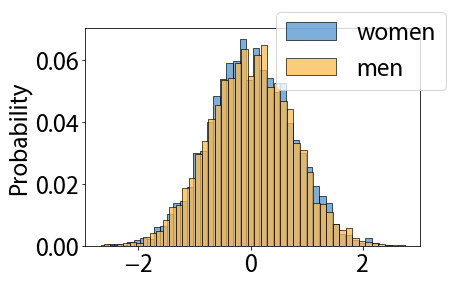

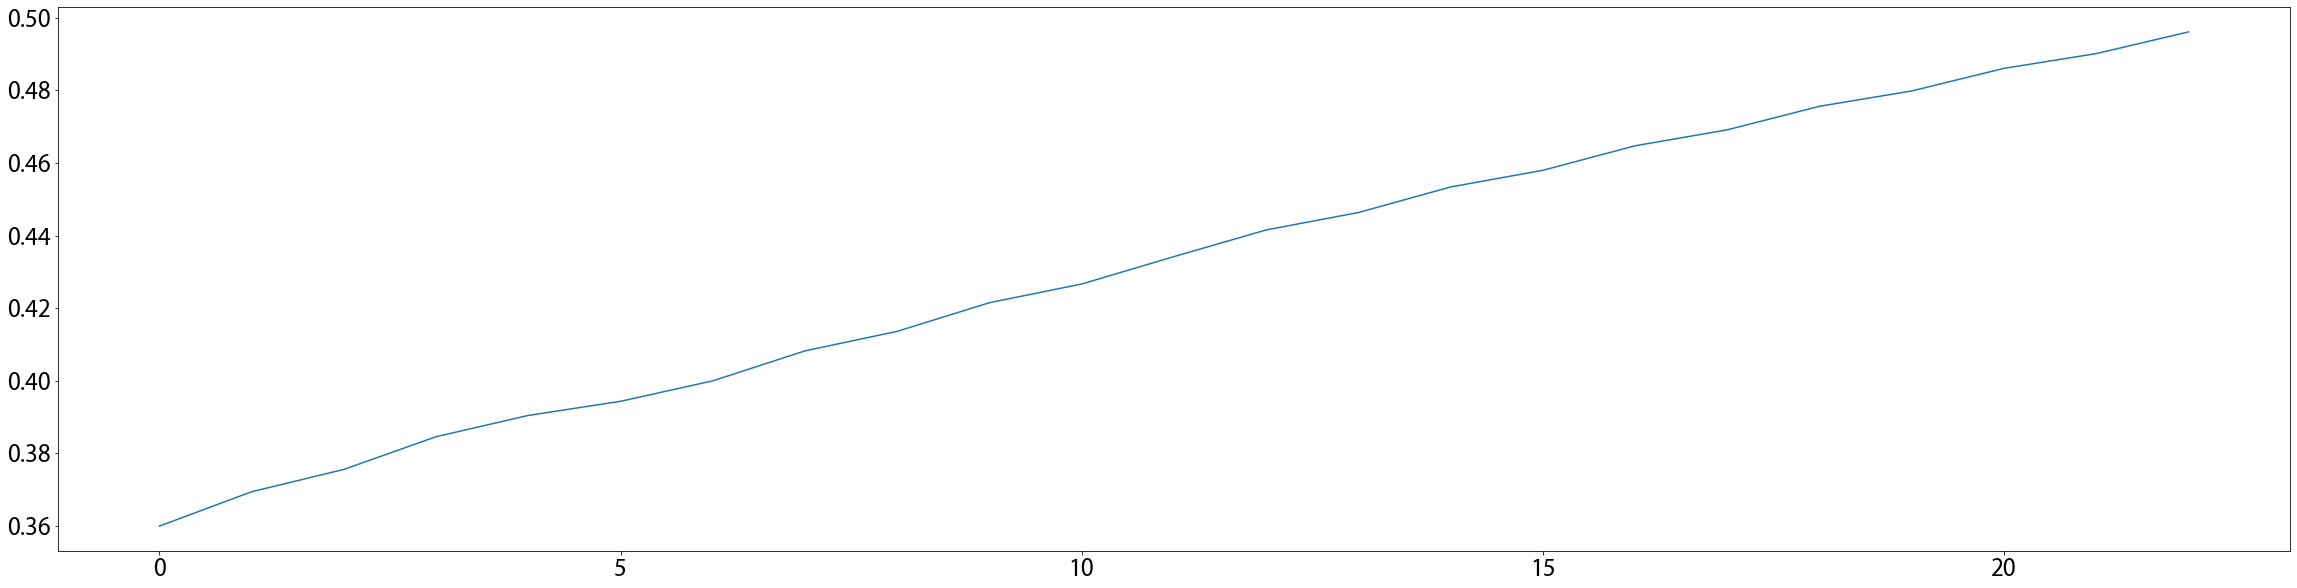

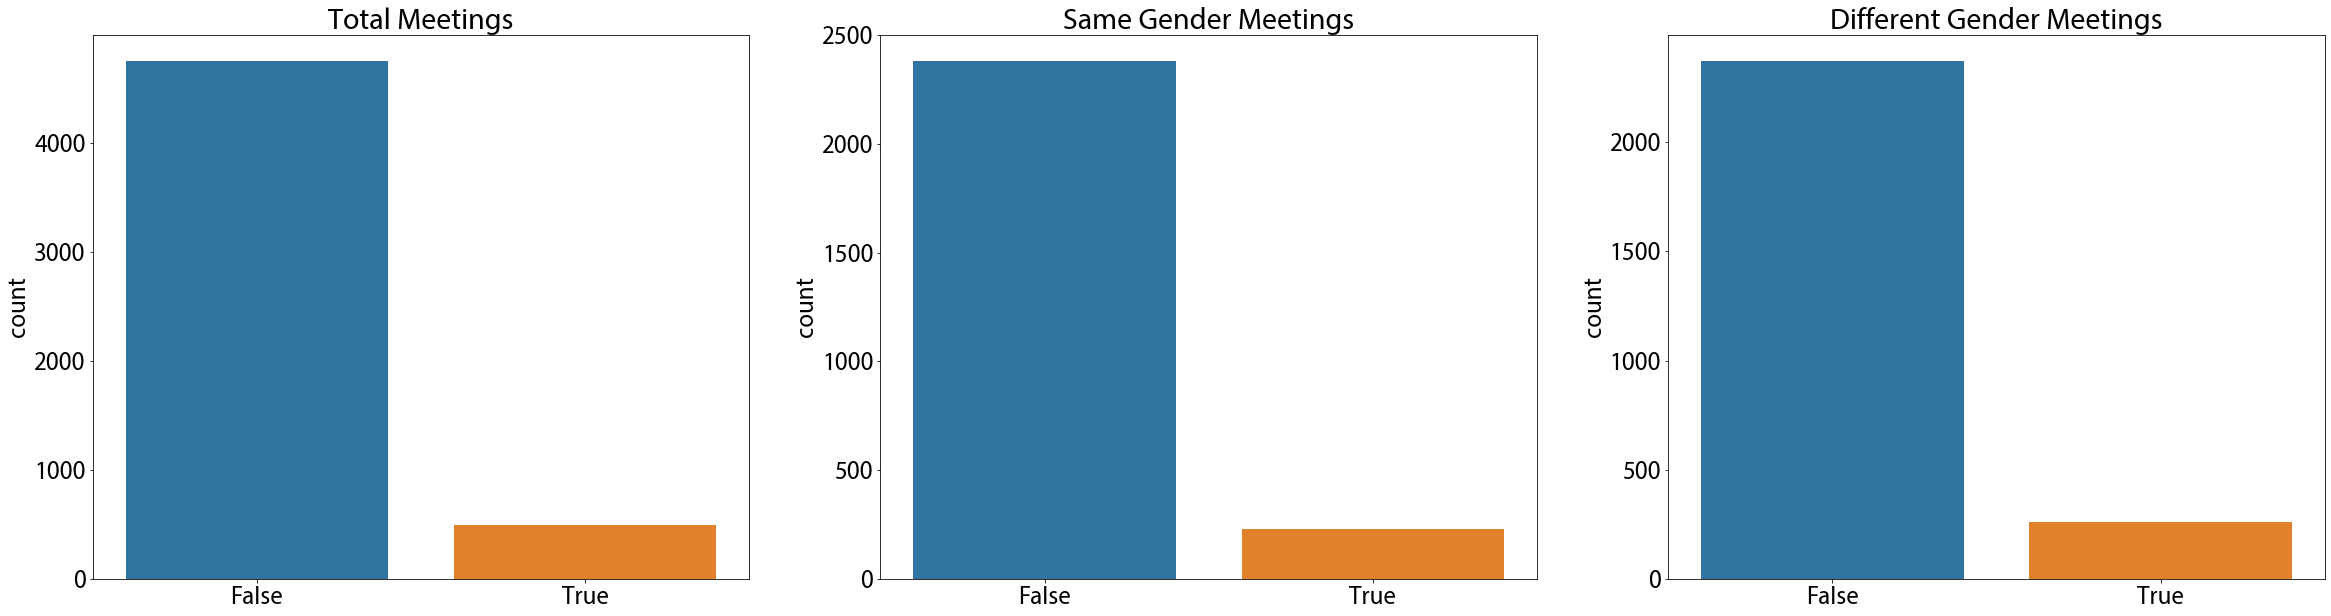

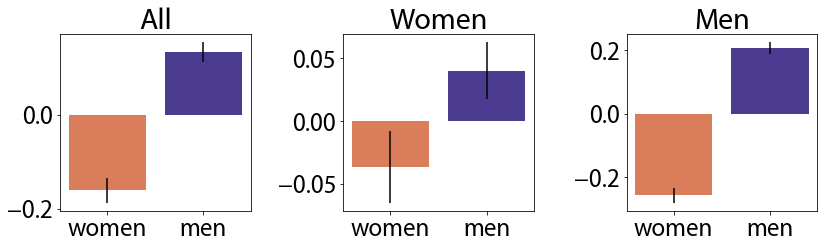

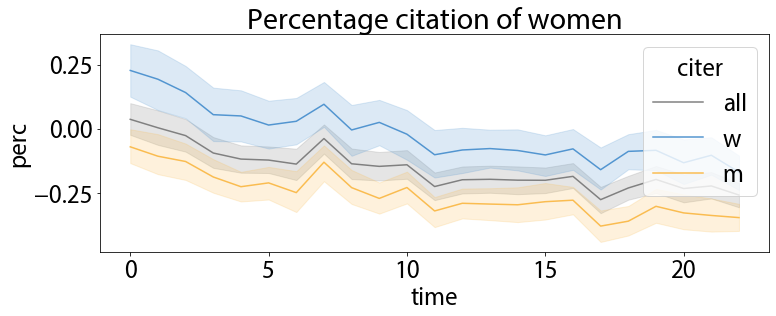

In [9]:
net_w = (.51,.01)
net_m = (.45,.01)
walk_w = (.60,.1)
walk_m = (.44,.1)
if meet_method == 'soc':
    meet_w = (0.04,0.005)
    meet_m = (0.06,0.005)
elif meet_method == 'bi':
    meet_w = (0.03,0.005)
    meet_m = (0.03,0.005)
learn_w = (0,.75)
learn_m = (0,.75)

meets_per_year = 10
ext = 'zeta_big'

f,ax = plt.subplots(1,1,figsize=(6,4))
sns.histplot(np.random.normal(loc=learn_w[0],scale=learn_w[1],size=5000), color=colors[2], stat='probability')
sns.histplot(np.random.normal(loc=learn_m[0],scale=learn_m[1],size=5000), color=colors[3], stat='probability')
f.legend(labels=['women','men'])
plt.savefig(f'../data/img/{ext}.pdf')

# generate authors
authors = []
for i in range(700): # we need this to be bigger than the number of authors used in the simulation, to make sure we dont run out when making random draws
    if np.random.rand(1)[0] >= woman_perc_f:
        gen = 'M'
    else:
        gen = 'W'
    # draw biases
    if gen == 'M':
        net = np.random.normal(loc=net_m[0],scale=net_m[1],size=1)[0]
        walk = skewnorm.rvs(10, loc=walk_m[0],scale=walk_m[1],size=1)[0]
        meet = np.random.normal(loc=meet_m[0],scale=meet_m[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_m[0],sigma=learn_m[1],size=1)[0]
    else:
        net = np.random.normal(loc=net_w[0],scale=net_w[1],size=1)[0]
        walk = np.random.normal(loc=walk_w[0],scale=walk_w[1],size=1)[0]
        meet = np.random.normal(loc=meet_w[0],scale=meet_w[1],size=1)[0]
        learn = np.random.lognormal(mean=learn_w[0],sigma=learn_w[1],size=1)[0]
    # make object
    a = Author(net,walk,meet,learn,gender=gen)
    a.init_network(g,node_2_gender,net_size_o,diam,c)
    authors.append(a)
    

# simulate meetings
w_index = [a.gender == 'W' for a in authors]
w_ind = np.where(w_index)
m_ind = np.where([not x for x in w_index])
ns = np.round(np.linspace(nAuthSt, nAuth, nYears))
ns_w = np.round(ns*np.linspace(woman_perc_i, woman_perc_f, nYears))
# build up time vary parameters, like authors, and gender percentage
# initialize
sim_params = {}
w = np.random.choice(w_ind[0],(1,int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
m = np.random.choice(m_ind[0],(1,nAuthSt - int(np.round((nAuthSt*woman_perc_i))))).tolist()[0]
w.extend(m)
sim_params[0] = {'author_idx':w,
                    'woman_perc':woman_perc_i,
                    'n':nAuthSt,}
for i in range(1,nYears):
    new_n = ns[i]
    dn = new_n - sim_params[i-1]['n']
    dw = ns_w[i] - sum([a.gender == 'W' for a in [authors[x] for x in sim_params[i-1]['author_idx']]])
    rem_auths = [j for j,a in enumerate(authors) if j not in sim_params[i-1]['author_idx']]
    new_w_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'W')]
    new_m_ind = [j for j,a in enumerate(authors) if (j in rem_auths) & (a.gender == 'M')]
    if dn > 0:
        a = []
        for j in range(int(dn)):
            if j <= dw:
                a.append(np.random.choice(new_w_ind).tolist())
            else:
                a.append(np.random.choice(new_m_ind).tolist())
        new_auths = sim_params[i-1]['author_idx'].copy()
        new_auths.extend(a)
        sim_params[i] = {'author_idx':new_auths,
                        'woman_perc':sum([a.gender == 'W' for a in [authors[x] for x in new_auths]])/new_n,
                        'n':new_n,}
    else:
        sim_params[i] = sim_params[i-1]

# proportion of women in the field
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
sns.lineplot(data=[x['woman_perc'] for x in sim_params.values()])

# run simulation
data = []
for i,b in enumerate(range(nYears)):
    #cProfile.run("tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'])")
    tmp = group_meet(sim_params[i]['n'], authors, sim_params[i]['author_idx'], meets_per_year)
    data.append(tmp)
    del tmp

# intialize final data structs
meets = {}; # keep track of when meetings were successful
net_size = []
bibs = {}
bibs_w = {}
bibs_m = {}
cite_perc = []
percs = [x['woman_perc'] for x in sim_params.values()]

# reformat data
cite_data = pd.DataFrame(columns=['perc','gen','time'])
prac_data = pd.DataFrame(columns=['prac','time','gen','citer'])
for i,d in enumerate(data):    
    curr_meets, ns, bs, bws, bms = d
    curr_meets = dict(zip(np.array(list(curr_meets.keys()))+((i)*nAuth),curr_meets.values()))
    meets.update(curr_meets)
    net_size.append(ns)
    bibs[i] = bs
    bibs_w[i] = bws
    bibs_m[i] = bms

# number of meetings
plt.rcParams.update({'font.size': 25})        
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values()], ax=ax[0])
ax[0].set_title('Total Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
               if (x['gender1'] == x['gender2'])], ax=ax[1])
ax[1].set_title('Same Gender Meetings')
sns.countplot(x=[x['meet12'] + x['meet21'] for x in meets.values() 
                 if (x['gender1'] != x['gender2'])], ax=ax[2])
ax[2].set_title('Different Gender Meetings')

# static plot
static_perc = np.empty((nYears,len(bibs[nYears-1])))
static_perc[:] = np.NaN
static_perc_w = np.empty((nYears,len(bibs_w[nYears-1])))
static_perc_w[:] = np.NaN
static_perc_m = np.empty((nYears,len(bibs_m[nYears-1])))
static_perc_m[:] = np.NaN
for i,b in enumerate(bibs.values()):
    # get all authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])
        
for i,b in enumerate(bibs_w.values()):
    # get all w authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_w[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

for i,b in enumerate(bibs_m.values()):
    # get all m authors citations at this time point
    for j,p in enumerate(b):
        # add to list
        static_perc_m[i][j] = np.mean([cite['gender'] == 'woman' for cite in p.values()])

plt.figure(figsize=(12,4))

plt.subplot(131)
amw = np.nanmean([(x-percs)/percs for x in static_perc.T])
asw = np.nanstd([(x-percs)/percs for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))
amm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])
asm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [amw, amm], color=colors)
plt.errorbar(['women','men'], [amw,amm], [asw, asm], fmt='none', color='k')
plt.title('All')
print('All citers (w): ' + str(amw) + '%, +/-' + str(asw))
print('All citers (m): ' + str(amm) + '%, +/-' + str(asm))

plt.subplot(132)
wmw = np.nanmean([(x-percs)/percs for x in static_perc_w.T])
wsw = np.nanstd([(x-percs)/percs for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))
wmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])
wsm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [wmw, wmm], color=colors)
plt.errorbar(['women','men'], [wmw,wmm],[wsw,wsm], fmt='none', color='k')
plt.title('Women')
print('W citers (w): ' + str(wmw) + '%, +/-' + str(wsw))
print('W citers (m): ' + str(wmm) + '%, +/-' + str(wsm))

plt.subplot(133)
mmw = np.nanmean([(x-percs)/percs for x in static_perc_m.T])
msw = np.nanstd([(x-percs)/percs for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))
mmm = np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])
msm = np.nanstd([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T])/np.sqrt(len(bibs[nYears-1]))

plt.bar(['women','men'], [mmw,mmm], color=colors)
plt.errorbar(['women','men'], [mmw,mmm],[msw,msm], fmt='none', color='k')
plt.title('Men')
print('M citers (w): ' + str(mmw) + '%, +/-' + str(msw))
print('M citers (m): ' + str(mmm) + '%, +/-' + str(msm))
plt.tight_layout()
plt.savefig(f'../data/img/static_cites_{ext}.pdf')

# stats
wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc.T],1),0)
print('All citers (w): ' + str(wt) + ', ' + str(wp))
print('All citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_w.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_w.T],1),0)
print('W citers (w): ' + str(wt) + ', ' + str(wp))
print('W citers (m): ' + str(mt) + ', ' + str(mp))

wt,wp = ttest_1samp(np.nanmean([(x-percs)/percs for x in static_perc_m.T],1),0)
mt,mp = ttest_1samp(np.nanmean([((1 - x) - (1 - np.array(percs)))/(1 - np.array(percs)) for x in static_perc_m.T],1),0)
print('M citers (w): ' + str(wt) + ', ' + str(wp))
print('M citers (m): ' + str(mt) + ', ' + str(mp))

cite_data = pd.DataFrame(columns=['perc','gen','citer','time'])
for i,b in bibs.items():
    curr_perc = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    tmp_data = pd.DataFrame({'perc': curr_perc, 
                             'gen':['w']*len(curr_perc),
                             'citer':['all']*len(curr_perc),
                             'time':[i]*len(curr_perc)})
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_w.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # womens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                              'citer':['w']*(len(curr_perc_w)+len(curr_perc_m)),
                              'gen':gen,
                              'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
for i,b in bibs_m.items():
    curr_perc_w = (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b]) - percs[i])/percs[i]
    curr_perc_m = (1 - (np.array([np.mean([cite['gender'] == 'woman' for cite in x.values()]) for x in b])) - (1 - percs[i]))/(1 - percs[i])    
    
    # mens citation by gender
    gen = ['w']*len(curr_perc_w)
    gen.extend(['m']*len(curr_perc_m))
    tmp_data = pd.DataFrame({'perc': np.concatenate((curr_perc_w, curr_perc_m)), 
                             'gen':gen, 
                             'citer':['m']*(len(curr_perc_w)+len(curr_perc_m)), 
                             'time':[i]*(len(curr_perc_w)+len(curr_perc_m))})    
    cite_data = pd.concat([cite_data,tmp_data])
    
f,ax = plt.subplots(1,1,figsize=(12,4))
sns.lineplot(data=cite_data[cite_data['gen'] == 'w'], x='time', y='perc', hue='citer',ax=ax, palette=['grey',colors[2],colors[3]])
ax.set_title('Percentage citation of women')
plt.savefig(f'../data/img/all_cite_w_{ext}.pdf')

# stats
X = sm.add_constant(range(nYears))
y = cite_data[(cite_data['citer'] == 'all') & (cite_data['gen'] == 'w')].groupby('time').mean().values
mod = sm.OLS(y, X)
res = mod.fit()
yw = cite_data[(cite_data['citer'] == 'w') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modw = sm.OLS(yw, X)
resw = modw.fit()
ym = cite_data[(cite_data['citer'] == 'm') & (cite_data['gen'] == 'w')].groupby('time').mean().values
modm = sm.OLS(ym, X)
resm = modm.fit()

print('All citers: ' + str(res.params[1]) + ', ' + str(res.pvalues[1]))
print('W citers: ' + str(resw.params[1]) + ', ' + str(resw.pvalues[1]))
print('M citers: ' + str(resm.params[1]) + ', ' + str(resm.pvalues[1]))

## Different learning threshold